# Descubrimientos de las reglas que deciden decisiones en modelos BPMN - Decision Mining

In [1]:
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, validation_curve, learning_curve
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
import time

from sklearn.tree import DecisionTreeClassifier

import seaborn as sns

Ejemplo gráfico del Decision Mining que queremos llevar a cabo:
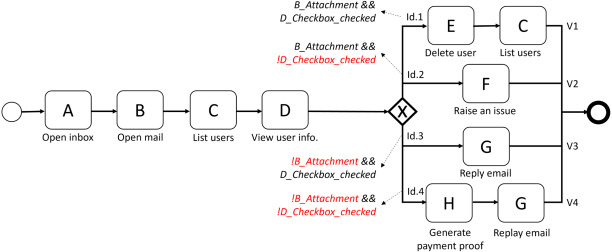

Instalación graphViz
https://www.youtube.com/watch?v=sOhA-azYzVk

### 1. Carga de datos

In [68]:
#datos sin preprocesar
df_bruto = pd.read_csv('./flattened_dataset 1.csv')

#datos preprocesados por Antonio para entrenmaiento 
# "le quito la variable objetivo para que al entrenar no la sepa, y codifico los valores categoricos (enabled, disabled, checked, unchecked) como numeros ordinales"
X = pd.read_csv('./preprocessed_df.csv')

In [69]:
#valores posibles de la variable objetivo
df_bruto['Variant'].unique()

array([4, 3, 2, 1], dtype=int64)

Observar contenido

In [70]:
print(df_bruto.shape)
print(X.shape)

(89, 1681)
(89, 1236)


In [71]:
df_bruto[:5]

,Unnamed: 0,Variant,MorKeyb_1_A,Coor_X_1_A,Coor_Y_1_A,Click_1_A,features.experiment.GUI_category.name.TextInput_1_A,NameApp_1_A,MorKeyb_2_B,Coor_X_2_B,...,sta_enabled_322.0-820.0_4_D,sta_enabled_513.0-1497.0_1_A,sta_enabled_853.0-1469.5_1_A,sta_enabled_1375.5-1504.5_1_A,sta_enabled_515.0-597.5_1_A,sta_enabled_514.0-1144.0_1_A,sta_enabled_1420.0-665.5_1_A,sta_enabled_830.5-440.5_1_A,sta_enabled_837.0-1035.0_1_A,sta_enabled_852.0-1353.0_1_A
0,1,4,1,1831,380,1,1,Mail,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,4,1,750,350,1,1,Mail,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,3,1,555,308,1,1,Mail,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,3,1,1019,523,1,1,Mail,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,3,1,632,283,1,1,Mail,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
X[:10]

,Unnamed: 0,numeric__Coor_X_1_A,numeric__Coor_Y_1_A,numeric__Coor_X_3_C,numeric__Coor_Y_3_C,status_categorical__sta_enabled_843.5-453.5_1_A,status_categorical__sta_enabled_838.0-559.0_1_A,status_categorical__sta_enabled_840.5-627.5_1_A,status_categorical__sta_enabled_836.5-688.0_1_A,status_categorical__sta_enabled_848.0-750.5_1_A,...,status_categorical__sta_enabled_322.0-820.0_4_D,status_categorical__sta_enabled_513.0-1497.0_1_A,status_categorical__sta_enabled_853.0-1469.5_1_A,status_categorical__sta_enabled_1375.5-1504.5_1_A,status_categorical__sta_enabled_515.0-597.5_1_A,status_categorical__sta_enabled_514.0-1144.0_1_A,status_categorical__sta_enabled_1420.0-665.5_1_A,status_categorical__sta_enabled_830.5-440.5_1_A,status_categorical__sta_enabled_837.0-1035.0_1_A,status_categorical__sta_enabled_852.0-1353.0_1_A
0,0,1831.0,380.0,736.0,401.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,750.0,350.0,428.0,385.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,555.0,308.0,441.0,180.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1019.0,523.0,538.0,358.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,632.0,283.0,444.0,447.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,1416.0,415.0,609.0,400.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6,773.0,349.0,375.0,326.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,1337.0,357.0,641.0,230.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8,1154.0,291.0,345.0,251.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,9,1876.0,448.0,515.0,423.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Extraigo la variable objetivo para aplicarselo a los algoritmos


In [73]:
y=df_bruto['Variant']
y[:5]

0    4
1    4
2    3
3    3
4    3
Name: Variant, dtype: int64

In [74]:
#unimos el dataset preprocesado con la variable objetivo

df_unido = pd.concat([X, y], axis=1)

### 2. Visualización de los datos

#### 2.1 Correlación de todas las variables con respecto a la variable objetivo

In [86]:
# Calcular la correlación de cada atributo con 'Variant'

correlaciones = df_unido.corrwith(df_unido['Variant']).to_frame('class_corr')

# Ordenar las correlaciones por valor absoluto, de mayor a menor
correlaciones = correlaciones['class_corr'].abs().sort_values(ascending=False)
correlaciones[:20]

Variant                                              1.000000
status_categorical__sta_enabled_757.5-594.0_2_B      0.883893
status_categorical__sta_enabled_754.5-772.5_2_B      0.883893
status_categorical__sta_enabled_717.5-606.5_2_B      0.883893
status_categorical__sta_enabled_867.5-672.5_2_B      0.883893
status_categorical__sta_enabled_712.5-890.0_2_B      0.883893
status_categorical__sta_enabled_1044.0-775.0_2_B     0.883893
status_categorical__sta_enabled_1047.0-593.5_2_B     0.883893
status_categorical__sta_enabled_715.5-806.0_2_B      0.883893
status_categorical__sta_checked_649.0-1110.5_4_D     0.353653
status_categorical__sta_enabled_842.0-1520.0_1_A     0.322524
status_categorical__sta_enabled_520.0-718.0_1_A      0.308713
status_categorical__sta_enabled_846.5-872.0_1_A      0.283066
status_categorical__sta_enabled_1359.5-1488.5_1_A    0.274381
status_categorical__sta_enabled_831.5-857.0_1_A      0.273179
status_categorical__sta_enabled_1120.0-1553.5_1_A    0.273179
status_c

In [87]:
df_unido

,Unnamed: 0,numeric__Coor_X_1_A,numeric__Coor_Y_1_A,numeric__Coor_X_3_C,numeric__Coor_Y_3_C,status_categorical__sta_enabled_843.5-453.5_1_A,status_categorical__sta_enabled_838.0-559.0_1_A,status_categorical__sta_enabled_840.5-627.5_1_A,status_categorical__sta_enabled_836.5-688.0_1_A,status_categorical__sta_enabled_848.0-750.5_1_A,...,status_categorical__sta_enabled_513.0-1497.0_1_A,status_categorical__sta_enabled_853.0-1469.5_1_A,status_categorical__sta_enabled_1375.5-1504.5_1_A,status_categorical__sta_enabled_515.0-597.5_1_A,status_categorical__sta_enabled_514.0-1144.0_1_A,status_categorical__sta_enabled_1420.0-665.5_1_A,status_categorical__sta_enabled_830.5-440.5_1_A,status_categorical__sta_enabled_837.0-1035.0_1_A,status_categorical__sta_enabled_852.0-1353.0_1_A,Variant
0,0,1831.0,380.0,736.0,401.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
1,1,750.0,350.0,428.0,385.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,2,555.0,308.0,441.0,180.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,3,1019.0,523.0,538.0,358.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,4,632.0,283.0,444.0,447.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,84,1805.0,352.0,527.0,477.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
85,85,1356.0,386.0,669.0,302.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
86,86,741.0,546.0,742.0,316.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4
87,87,920.0,478.0,345.0,475.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1


#### 2.2 Número de registros por cada clase (cada salida de la decisión)

<Axes: xlabel='Variant', ylabel='count'>

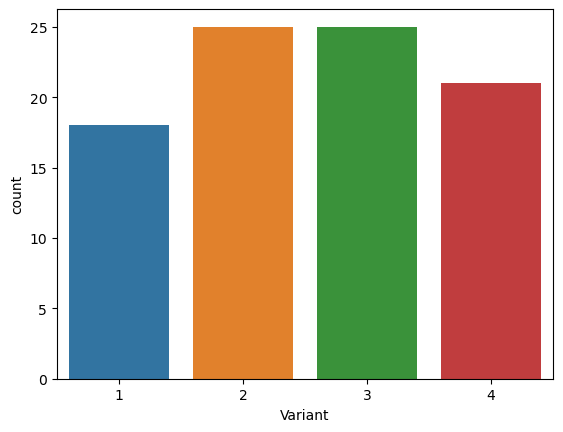

In [76]:
sns.countplot(df_unido, x = "Variant")

### 3. Clasificación - Capa 1

#### 3.1 Evaluación de algoritmos mediante validación cruzada

In [77]:
# Entrenar el árbol de decisión con el algoritmo C4.5
c45 = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=5)  # Criterio de división basado en la entropía (C4.5)

cross_val_score(c45, X, y, cv=5, scoring='balanced_accuracy').mean()

1.0

#### 3.2 Entrenamiento de modelo predictivo

In [78]:
from sklearn import metrics

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

c45.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = c45.predict(X_test)

# Calcular la precisión del modelo
accuracy = metrics.accuracy_score(y_test, y_pred)

print("Precisión:", accuracy)

Precisión: 1.0


#### 3.3 Me quedo con las reglas obtenidas para cada uno de los valores de la variable objetivo

In [80]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names, classes):
    """
    Función que recorre las ramas de un árbol de decisión y extrae las reglas
    obtenidas para clasificar cada una de las variables objetivo
    
    Parametros:
    - tree: El modelo árbol de decisión.
    - feature_names: Lista de los atributos del dataset.
    - classes: Clases posibles de la variable objetivo, ordenada ascendentemente
    """
    # accede al objeto interno tree_ del árbol de decisión
    tree_ = tree.tree_
    print("Indices de los atributos de los nodos de decision. "
          + str(tree_.feature))
    
    #crea una lista con los nombres de los atributos que se utilizan en los
    #nodos de decisión del arbol
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("Nombres de los atributos de los nodos de decision (si es ndefined=nodo Hoja)  "
          + str(feature_name))
    
    #funcion recursiva (node-indice del nodo actual, 
    #depth-profundidad actual del arbol, 
    #parent_rule-regla acumulada desde la raíz hasta el nodo actual. )
    
    def recurse(node, depth, parent_rule,classes): 
        indent = "  " * depth
        
        #si el nodo actual no es una hoja, vamos a calcular las reglas para los hijos
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            
            name = feature_name[node] #nombre deel atributo del nodo
            
            #valor de la variable que divide el nodo (pago>10) --> sería 10
            threshold = tree_.threshold[node] 
            
            #crea las reglas para los hijos nodos izq y derecha
            left_rule = parent_rule + [f"{name} <= {threshold:.2f}"]
            right_rule = parent_rule + [f"{name} > {threshold:.2f}"]
            
            #llamadas recursivas para los nodos hijo izquierdo y derecho, incrementando depth en 1 y pasando la regla actualizada.
            recurse(tree_.children_left[node], depth + 1, left_rule, classes)
            recurse(tree_.children_right[node], depth + 1, right_rule, classes)
        
        # en caso de que sea una hoja el nodo actual:
        else:
            rule = " & ".join(parent_rule) #une cada elemento de la lista de reglas con AND
            # tree_.value[node] devuelve un array con el numero de individuos 
            #que caen para cada clase de la variable objetivo
            #ej: [[ 0. 22.  0.  0.]] , devolvería la clase 2 , ya que internamente 
            #sklearn maneja las clases ordenandolas ascendentemente [1,2,3,4]
            
            target = tree_.value[node].argmax()
            
            print(str(tree_.value[node]))
            
            print(f"Rule: IF {rule} THEN Class: {classes[target]}")

    #inicializa recurse, desde nodo raiz, profundidad 1, lista de reglas vacia
    recurse(0, 1, [], classes)


In [81]:
feature_names = X.columns
tree_to_code(c45, feature_names, np.unique(y))

Indices de los atributos de los nodos de decision. [62 72 -2 -2 72 -2 -2]
Nombres de los atributos de los nodos de decision (si es ndefined=nodo Hoja)  ['status_categorical__sta_enabled_757.5-594.0_2_B', 'status_categorical__sta_checked_649.0-1110.5_4_D', 'undefined!', 'undefined!', 'status_categorical__sta_checked_649.0-1110.5_4_D', 'undefined!', 'undefined!']
[[ 0. 22.  0.  0.]]
Rule: IF status_categorical__sta_enabled_757.5-594.0_2_B <= 0.50 & status_categorical__sta_checked_649.0-1110.5_4_D <= 0.50 THEN Class: 2
[[14.  0.  0.  0.]]
Rule: IF status_categorical__sta_enabled_757.5-594.0_2_B <= 0.50 & status_categorical__sta_checked_649.0-1110.5_4_D > 0.50 THEN Class: 1
[[ 0.  0.  0. 14.]]
Rule: IF status_categorical__sta_enabled_757.5-594.0_2_B > 0.50 & status_categorical__sta_checked_649.0-1110.5_4_D <= 0.50 THEN Class: 4
[[ 0.  0. 21.  0.]]
Rule: IF status_categorical__sta_enabled_757.5-594.0_2_B > 0.50 & status_categorical__sta_checked_649.0-1110.5_4_D > 0.50 THEN Class: 3


**TO DO:**
- resolver casuistica (aunque no se da con estos datos) de cuando hay dos hojas de la misma clase predicha, unir con OR las expresiones logicas de ambas ramas
- visualizar arbol generado con grazviz

#### 3.4 Me quedo con los registros mal clasificados

In [85]:
# Comparar las predicciones con las etiquetas verdaderas para identificar los registros mal clasificados
indices_fallados = (y_pred != y_test)
# Obtener los registros mal clasificados
registros_fallados = X_test[indices_fallados]

# Convertir los registros mal clasificados en un DataFrame si lo deseas
df_fallados = pd.DataFrame(data=registros_fallados, columns=X.columns)
df_fallados

,Unnamed: 0,numeric__Coor_X_1_A,numeric__Coor_Y_1_A,numeric__Coor_X_3_C,numeric__Coor_Y_3_C,status_categorical__sta_enabled_843.5-453.5_1_A,status_categorical__sta_enabled_838.0-559.0_1_A,status_categorical__sta_enabled_840.5-627.5_1_A,status_categorical__sta_enabled_836.5-688.0_1_A,status_categorical__sta_enabled_848.0-750.5_1_A,...,status_categorical__sta_enabled_322.0-820.0_4_D,status_categorical__sta_enabled_513.0-1497.0_1_A,status_categorical__sta_enabled_853.0-1469.5_1_A,status_categorical__sta_enabled_1375.5-1504.5_1_A,status_categorical__sta_enabled_515.0-597.5_1_A,status_categorical__sta_enabled_514.0-1144.0_1_A,status_categorical__sta_enabled_1420.0-665.5_1_A,status_categorical__sta_enabled_830.5-440.5_1_A,status_categorical__sta_enabled_837.0-1035.0_1_A,status_categorical__sta_enabled_852.0-1353.0_1_A
